# BB-EIT: Prediction with 5-Fold CV

Dataset: Proteins_Data_Augmented_Heteroscedastic.csv

Extended Features: Thickness, CA, ZP, pI, MW

Scaling: None

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

c:\Users\shiws\miniforge3\envs\rdkit\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
protein_data = pd.read_csv("Proteins_Data_w_Predicted_Value_100.csv")
protein_data

,Ref,Sample,Type,Protein adsorption / ng cm-2,Protein MW / kDa,Protein Charge (pI),Predicted Zeta (mV),Predicted CA (deg),Thickness (nm),SMILES
0,https://pubs.acs.org/doi/full/10.1021/acs.jpcc...,PBMA,BSA,236.600000,66.5,4.7,-18.940662,81.844615,11.962000,C=C(C)C(=O)OCCCC
1,https://pubs.acs.org/doi/full/10.1021/acs.jpcc...,PHEMA,BSA,36.300000,66.5,4.7,-12.367573,47.561973,16.822000,C=C(C)C(=O)OCCO
2,https://pubs.acs.org/doi/full/10.1021/acs.jpcc...,PmOEGMA,BSA,16.900000,66.5,4.7,-8.504514,51.628971,17.900000,C=C(C)C(=O)OCCOCCOCCOCCOC
3,https://pubs.acs.org/doi/full/10.1021/acs.jpcc...,PMEA,BSA,4.800000,66.5,4.7,-2.474034,53.048590,19.788958,C=CC(=O)OCCOC
4,https://pubs.acs.org/doi/full/10.1021/acs.jpcc...,PAEMA,BSA,454.400000,66.5,4.7,26.610718,44.128792,9.222500,C=C(C)C(=O)OCC[NH3+].[Cl-]
...,...,...,...,...,...,...,...,...,...,...
6395,https://onlinelibrary.wiley.com/doi/full/10.10...,PNMEP,Fib,58.394448,340.0,5.8,-12.517403,25.857781,50.000000,CC(=C)C(OCCN1C(=O)CCC1)=O
6396,https://onlinelibrary.wiley.com/doi/full/10.10...,PNMEP,Fib,61.248446,340.0,5.8,-12.517403,25.857781,50.000000,N1(C(=O)CCC1)CCOC(C(C)=C)=O
6397,https://onlinelibrary.wiley.com/doi/full/10.10...,PNMEP,Fib,67.948052,340.0,5.8,-12.517403,25.857781,50.000000,O=C1CCCN1CCOC(=O)C(C)=C
6398,https://onlinelibrary.wiley.com/doi/full/10.10...,PNMEP,Fib,61.598622,340.0,5.8,-12.517403,25.857781,50.000000,C1C(=O)N(CCOC(=O)C(=C)C)CC1


In [3]:
CHEMBERT_MODEL = "seyonec/ChemBERTa-zinc-base-v1"
tokenizer = AutoTokenizer.from_pretrained(CHEMBERT_MODEL)
chembert = AutoModel.from_pretrained(CHEMBERT_MODEL)
for param in chembert.parameters():
    param.requires_grad = False

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [ ]:
class PolymerDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.smiles = dataframe["SMILES"].values
        self.features = dataframe[["Protein Charge (pI)", "Thickness (nm)", "Predicted CA (deg)", "Predicted Zeta (mV)", "Protein MW / kDa"]].values
        self.amount = dataframe["Protein adsorption / ng cm-2"].values
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        encoding = self.tokenizer(self.smiles[idx], return_tensors="pt", padding="max_length",
                                  truncation=True, max_length=128)
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)
        protein_features = torch.tensor(self.features[idx], dtype=torch.float32)
        amount = torch.tensor(self.amount[idx], dtype=torch.float32)
        return input_ids, attention_mask, protein_features, amount

class ChemBERTRegressor(nn.Module):
    def __init__(self, chembert, num_features=5, hidden_dim=256):
        super(ChemBERTRegressor, self).__init__()
        self.chembert = chembert
        self.fc1 = nn.Linear(768 + num_features, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, input_ids, attention_mask, protein_features):
        with torch.no_grad():
            outputs = self.chembert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state[:, 0, :]  
        x = torch.cat((pooled_output, protein_features), dim=1)
        x = self.relu(self.fc1(x))
        return self.fc2(x).squeeze()
    
def evaluate_model(model, data_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for input_ids, attention_mask, physical_features, amount in data_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            physical_features = physical_features.to(device)
            outputs = model(input_ids, attention_mask, physical_features)
            y_true.extend(amount.numpy())
            y_pred.extend(outputs.cpu().numpy())
    return np.array(y_true), np.array(y_pred)

In [5]:
data = protein_data[["SMILES",
                     "Protein adsorption / ng cm-2",
                     "Protein Charge (pI)", 
                     "Thickness (nm)",
                     "Predicted CA (deg)",
                     "Predicted Zeta (mV)", 
                     "Protein MW / kDa"]]
train_df, test_df = train_test_split(protein_data, test_size=0.2, random_state=42)

In [6]:
kf = KFold(n_splits=5)
models = []
rmse = []
r2 = []
train_losses = []

In [7]:
for fold, (train_idx, val_idx) in enumerate(kf.split(train_df)):
    print(f"Training fold {fold+1}")
    train_fold_df = train_df.iloc[train_idx].reset_index(drop=True)
    val_fold_df = train_df.iloc[val_idx].reset_index(drop=True)
    
    train_dataset = PolymerDataset(train_fold_df, tokenizer)
    val_dataset = PolymerDataset(val_fold_df, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    model = ChemBERTRegressor(chembert)

    model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.5)
    
    best_loss, patience, counter = float("inf"), 15, 0
    epochs = 120
    train_losses_fold = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for input_ids, attention_mask, features, amount in train_loader:
            input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
            features, amount = features.to(device), amount.to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, features)
            loss = criterion(outputs, amount)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * input_ids.size(0)
        
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses_fold.append(epoch_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, LR: {current_lr:.6f}")
        
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping")
                break
    
    train_losses.append(train_losses_fold)
    models.append(model)
    
    # Validation
    print("Evaluating on validation set...")
    train_y_true, train_y_pred = evaluate_model(model, train_loader)
    val_y_true, val_y_pred = evaluate_model(model, val_loader)
    train_rmse = np.sqrt(mean_squared_error(train_y_true, train_y_pred))
    train_r2 = r2_score(train_y_true, train_y_pred)
    val_rmse = np.sqrt(mean_squared_error(val_y_true, val_y_pred))
    val_r2 = r2_score(val_y_true, val_y_pred)
    print(f"Fold {fold+1} - Train RMSE: {train_rmse:.4f}, Train R2: {train_r2:.4f}")
    print(f"Fold {fold+1} - Val RMSE: {val_rmse:.4f}, Val R2: {val_r2:.4f}")

    rmse.append(val_rmse)
    r2.append(val_r2)
    if fold == 0 or val_r2 > max(r2):
        best_model = model
        best_actuals = val_y_true
        best_protein_label = val_fold_df["Protein Charge (pI)"].values
        best_predictions = val_y_pred
        best_rmse = val_rmse
        best_r2 = val_r2


Training fold 1
Epoch 1/120, Loss: 39056.2909, LR: 0.010000
Epoch 2/120, Loss: 26172.9424, LR: 0.010000
Epoch 3/120, Loss: 20833.9285, LR: 0.010000
Epoch 4/120, Loss: 16446.1611, LR: 0.010000
Epoch 5/120, Loss: 13710.9804, LR: 0.010000
Epoch 6/120, Loss: 12005.5763, LR: 0.010000
Epoch 7/120, Loss: 11589.3459, LR: 0.010000
Epoch 8/120, Loss: 11654.5279, LR: 0.010000
Epoch 9/120, Loss: 11177.2442, LR: 0.010000
Epoch 10/120, Loss: 10421.3720, LR: 0.010000
Epoch 11/120, Loss: 10621.9180, LR: 0.010000
Epoch 12/120, Loss: 9995.2131, LR: 0.010000
Epoch 13/120, Loss: 9727.4008, LR: 0.010000
Epoch 14/120, Loss: 10266.7455, LR: 0.010000
Epoch 15/120, Loss: 10417.2647, LR: 0.010000
Epoch 16/120, Loss: 9371.1131, LR: 0.010000
Epoch 17/120, Loss: 8967.3808, LR: 0.010000
Epoch 18/120, Loss: 9316.9470, LR: 0.010000
Epoch 19/120, Loss: 9004.0202, LR: 0.010000
Epoch 20/120, Loss: 9436.7159, LR: 0.010000
Epoch 21/120, Loss: 8853.5717, LR: 0.010000
Epoch 22/120, Loss: 9073.5786, LR: 0.010000
Epoch 23/120

In [8]:
i = 0
for model in models:
    torch.save(model.state_dict(), f"R2D2_All_All_fold_{i}.pth")
    i += 1

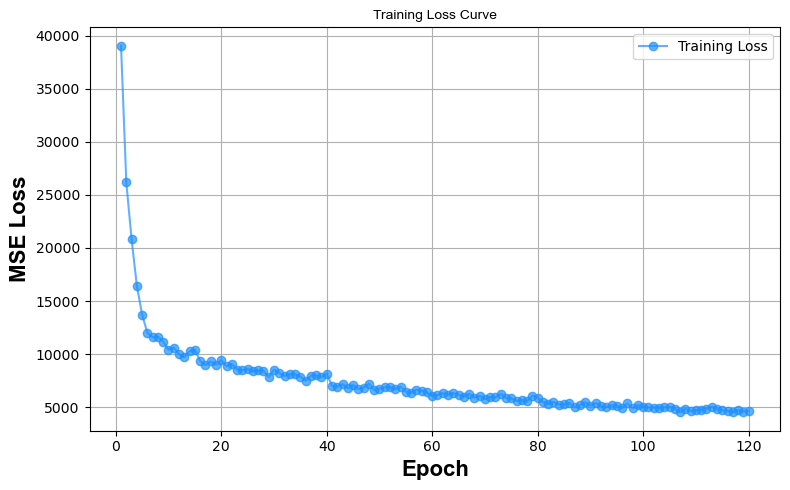

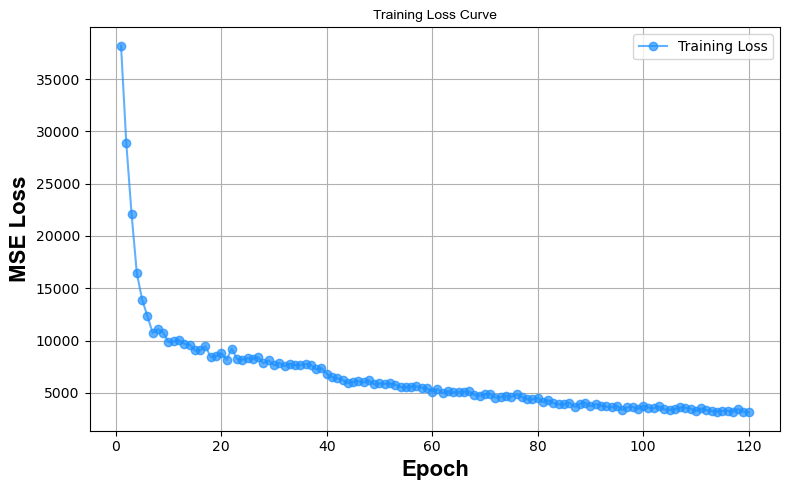

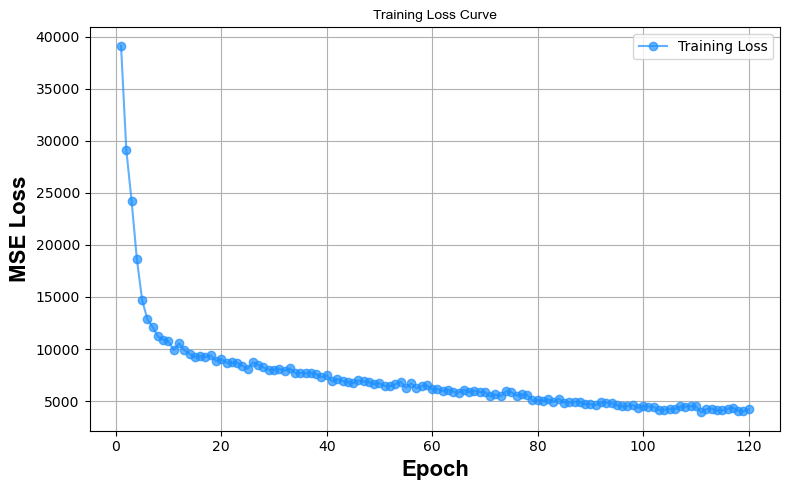

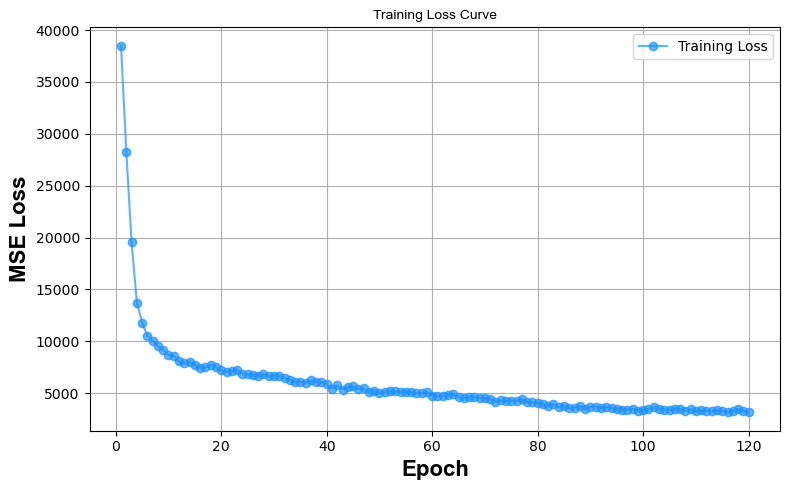

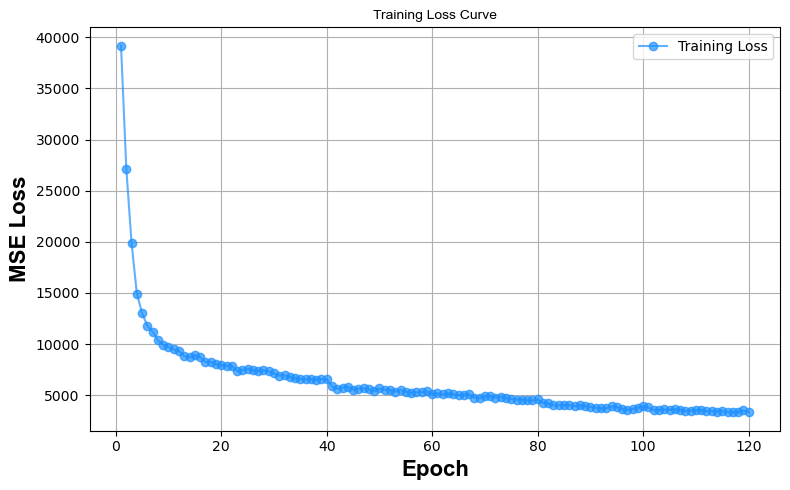

In [ ]:
for i in range(len(train_losses)):
    plt.figure(figsize=(8, 5))
    fold_losses = train_losses[i]
    plt.title(f'Training Loss for Fold {i+1}')
    plt.plot(range(1, len(fold_losses) + 1), fold_losses, marker="o", label="Training Loss", color="dodgerblue", alpha=0.7)
    plt.xlabel("Epoch", fontsize=16, fontweight="bold", font="Arial")
    plt.ylabel("MSE Loss", fontsize=16, fontweight="bold", font="Arial")
    plt.title("Training Loss Curve", fontsize=24, fontweight="bold", font="Arial")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    #plt.savefig("training_loss_curve.png")
    plt.show()

In [ ]:
loaded_models = []
for i in range(5):
    model = ChemBERTRegressor(chembert)
    model.load_state_dict(torch.load(f"R2D2_All_All_fold_{i}.pth"))
    model.to(device)
    model.eval()
    loaded_models.append(model)

print(f"Loaded {len(loaded_models)} models from 5-fold cross-validation")

Loaded 5 models from 5-fold cross-validation


In [8]:
models = loaded_models

In [ ]:
training_predictions = []
for i in range(len(models)):
    train_all, train_predictions_fold = evaluate_model(models[i], DataLoader(PolymerDataset(train_df, tokenizer), batch_size=32, shuffle=False))
    training_predictions.append(train_predictions_fold)
training_predictions_mean = np.mean(training_predictions, axis=0)
  
training_prediction_std = np.std(training_predictions, axis=0)

test_predictions = []
for i in range(len(models)):
    test_all, test_predictions_fold = evaluate_model(models[i], DataLoader(PolymerDataset(test_df, tokenizer), batch_size=32, shuffle=False))
    test_predictions.append(test_predictions_fold)
test_predictions_mean = np.mean(test_predictions, axis=0)

test_prediction_std = np.std(test_predictions, axis=0)

rmse_train = np.sqrt(mean_squared_error(train_df["Protein adsorption / ng cm-2"].values, training_predictions_mean))
r2_train = r2_score(train_df["Protein adsorption / ng cm-2"].values, training_predictions_mean)
rmse_test = np.sqrt(mean_squared_error(test_df["Protein adsorption / ng cm-2"].values, test_predictions_mean))
r2_test = r2_score(test_df["Protein adsorption / ng cm-2"].values, test_predictions_mean)

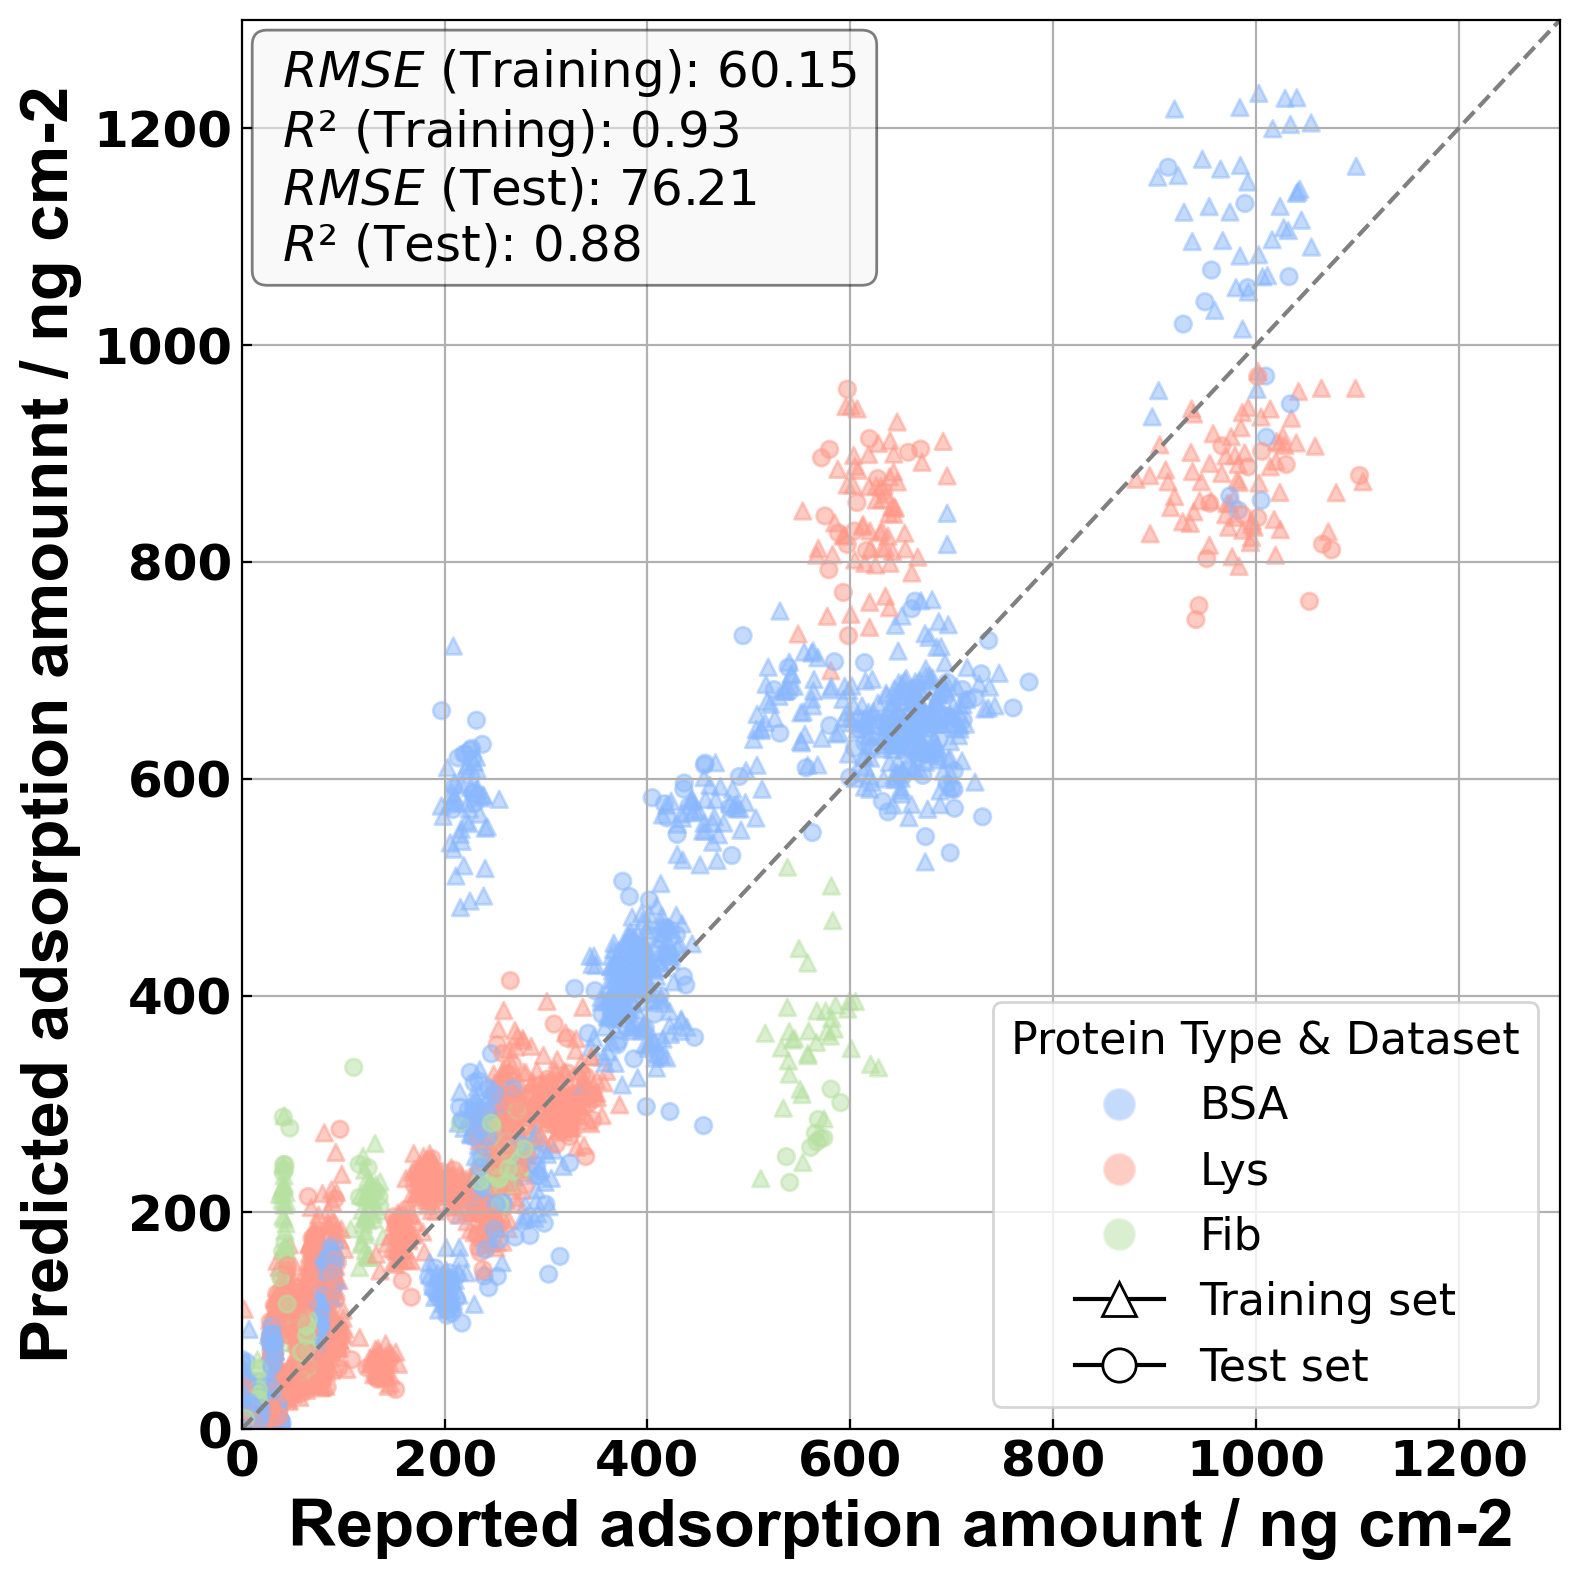

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=200)
ax.set_xlim([0, 1300])
ax.set_ylim([0, 1300])

protein_colors = {'BSA': '#8ab8fe',
                  'Lys': '#ff9a8a',
                  'Fib': '#b7e1a1'}

def get_protein_type(pi_value):
    if pi_value == 4.7:
        return 'BSA'
    elif pi_value == 11.0:
        return 'Lys'
    elif pi_value == 5.8:
        return 'Fib'
    else:
        return 'Unknown'

train_colors = [protein_colors[get_protein_type(pi)] for pi in train_df["Protein Charge (pI)"]]
test_colors = [protein_colors[get_protein_type(pi)] for pi in test_df["Protein Charge (pI)"]]

scatter_train = ax.scatter(train_all, training_predictions_mean,
                          c=train_colors, alpha=0.5, marker="^", label="Training set")
scatter_test = ax.scatter(test_all, test_predictions_mean,
                         c=test_colors, alpha=0.5, marker="o", label="Test set")

ax.set_xlabel("Reported adsorption amount / ng cm-2", fontsize=24, fontweight="bold", font="Arial")
ax.set_ylabel("Predicted adsorption amounnt / ng cm-2", fontsize=24, fontweight="bold", font="Arial")

new_ticks = [0, 200, 400, 600, 800, 1000, 1200]
plt.xticks(new_ticks, fontweight="bold")
plt.yticks(new_ticks, fontweight="bold")
ax.tick_params(labelsize="18", direction="in")


Axis_line = np.linspace(*ax.get_xlim(), 2)
ax.plot(Axis_line, Axis_line, transform=ax.transAxes, linestyle="--",
                linewidth=1.5, color="gray", label="1:1 Line")

ax.text(25,1275,
                        " $RMSE$ (Training): "+str(round(rmse_train, 2))+" "
                        "\n $R\u00b2$ (Training): "+str(round(r2_train, 2))+" "
                        "\n $RMSE$ (Test): "+str(round(rmse_test, 2))+" "  
                        "\n $R\u00b2$ (Test): "+str(round(r2_test, 2))+" ",
                        verticalalignment="top", horizontalalignment="left",fontsize=18,
                        bbox={"boxstyle":"round,pad=0.3",
                                  "edgecolor":"black",
                                  "facecolor":"whitesmoke",
                                  "alpha":0.5, "pad":1})


bsa_legend = Line2D([0], [0], marker='o', color='w', markerfacecolor='#8ab8fe', markersize=8, label='BSA', alpha=0.5)
lys_legend = Line2D([0], [0], marker='o', color='w', markerfacecolor='#ff9a8a', markersize=8, label='Lys', alpha=0.5)
fib_legend = Line2D([0], [0], marker='o', color='w', markerfacecolor='#b7e1a1', markersize=8, label='Fib', alpha=0.5)

train_legend = Line2D([0], [0], marker='^', color='black', markerfacecolor='w', markersize=8, label='Training set')
test_legend = Line2D([0], [0], marker='o', color='black', markerfacecolor='w', markersize=8, label='Test set')

combined_handles = [bsa_legend, lys_legend, fib_legend, train_legend, test_legend]
combined_labels = ["BSA", "Lys", "Fib", "Training set", "Test set"]

ax.legend(combined_handles, combined_labels, 
          title="Protein Type & Dataset", 
          loc="lower right", 
          fontsize=16, 
          title_fontsize=16, 
          markerscale=1.5)

ax.grid(True)
plt.tight_layout()
plt.show()


# Unknown Polymer and Proteins

In [11]:
pspe = pd.read_csv("PSPE_data.csv")
pspe = pspe[["SMILES", "Protein adsorption / ng cm-2", "Protein Charge (pI)", "Thickness (nm)", "Predicted CA (deg)", "Predicted Zeta (mV)", "Protein MW / kDa"]]
pspe_dataset = PolymerDataset(pspe, tokenizer)
pspe["Protein adsorption / ng cm-2"]

0    79.0
1     8.7
Name: Protein adsorption / ng cm-2, dtype: float64

In [12]:
pspe_predictions = []
for i in range(len(models)):
    pspe_all, pspe_predictions_fold = evaluate_model(models[i], DataLoader(pspe_dataset, batch_size=32, shuffle=False))
    pspe_predictions.append(pspe_predictions_fold)

pspe_predictions_mean = np.mean(pspe_predictions, axis=0)
pspe_prediction_std = np.std(pspe_predictions, axis=0)
pspe_prediction_std = np.std(pspe_predictions, axis=0)

print(f"Mean predictions: {pspe_predictions_mean}")

Mean predictions: [68.634155 15.568027]
